In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout

!pip install fastparquet
!pip install shap


In [13]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Wed Sep  6 00:44:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
# Read the processed dataset.
# semg_df = pd.read_parquet('/content/drive/MyDrive/sEMG-HAR/semg_extracted_features_only', engine='fastparquet')
semg_df = pd.read_parquet('/content/drive/MyDrive/sEMG-HAR/semg_extracted_more_features', engine='fastparquet')

semg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Columns: 483 entries, subject_id to semg_5_tfd_arcoeffs
dtypes: float64(340), int32(113), object(30)
memory usage: 3.8+ MB


In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences

NO_WINDOWS = 10

non_scalar_features = ['activity', 'semg_1_fd_fft', 'semg_2_fd_fft', 'semg_3_fd_fft', 'semg_4_fd_fft', 'semg_5_fd_fft',
                      'semg_1_fd_psd', 'semg_2_fd_psd', 'semg_3_fd_psd', 'semg_4_fd_psd', 'semg_5_fd_psd',
                      'semg_1_tfd_stft', 'semg_2_tfd_stft', 'semg_3_tfd_stft', 'semg_4_tfd_stft', 'semg_5_tfd_stft',
                      'semg_1_tfd_mfcc', 'semg_2_tfd_mfcc', 'semg_3_tfd_mfcc', 'semg_4_tfd_mfcc', 'semg_5_tfd_mfcc',
                      'semg_1_tfd_hjorth', 'semg_2_tfd_hjorth', 'semg_3_tfd_hjorth', 'semg_4_tfd_hjorth', 'semg_5_tfd_hjorth',
                      'semg_1_tfd_arcoeffs', 'semg_2_tfd_arcoeffs', 'semg_3_tfd_arcoeffs', 'semg_4_tfd_arcoeffs', 'semg_5_tfd_arcoeffs']

scalar_X = semg_df.drop(columns=non_scalar_features)

non_scalar_features = ['semg_1_fd_fft', 'semg_2_fd_fft', 'semg_3_fd_fft', 'semg_4_fd_fft', 'semg_5_fd_fft',
                      'semg_1_fd_psd', 'semg_2_fd_psd', 'semg_3_fd_psd', 'semg_4_fd_psd', 'semg_5_fd_psd',
                      'semg_1_tfd_stft', 'semg_2_tfd_stft', 'semg_3_tfd_stft', 'semg_4_tfd_stft', 'semg_5_tfd_stft',
                      'semg_1_tfd_mfcc', 'semg_2_tfd_mfcc', 'semg_3_tfd_mfcc', 'semg_4_tfd_mfcc', 'semg_5_tfd_mfcc',
                      'semg_1_tfd_hjorth', 'semg_2_tfd_hjorth', 'semg_3_tfd_hjorth', 'semg_4_tfd_hjorth', 'semg_5_tfd_hjorth',
                      'semg_1_tfd_arcoeffs', 'semg_2_tfd_arcoeffs', 'semg_3_tfd_arcoeffs', 'semg_4_tfd_arcoeffs', 'semg_5_tfd_arcoeffs']

non_scalar_X = semg_df[non_scalar_features]
y = semg_df['activity'].astype('int')

# One-hot encoding for the labels
y = to_categorical(y-1, num_classes=21)

# Extract the 'activity' column from the one-hot encoded labels
activity_labels = np.argmax(y, axis=1)

# Split data into training and validation sets while preserving class proportions
scalar_X_train, scalar_X_val, non_scalar_X_train, non_scalar_X_val, y_train, y_val = train_test_split(
    scalar_X, non_scalar_X, y, test_size=0.2, random_state=42, stratify=activity_labels
)


# Standardize the scalar data
scaler = StandardScaler()
scalar_X_train_standardized = scaler.fit_transform(scalar_X_train)
scalar_X_val_standardized = scaler.transform(scalar_X_val)

scalar_X_train_list = scalar_X_train.values
scalar_X_val_list = scalar_X_val.values
non_scalar_train_X_list = non_scalar_X_train.values
non_scalar_val_X_list = non_scalar_X_val.values


# Apply the scaler to the list-type columns
for col in non_scalar_X_train.columns:
    non_scalar_X_train.loc[:, col] = non_scalar_X_train[col].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten().tolist())

# Apply the scaler to the list-type columns
for col in non_scalar_X_val.columns:
    non_scalar_X_val.loc[:, col] = non_scalar_X_val[col].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten().tolist())

In [18]:
max_sequence_length = max(len(col) for sequence in non_scalar_train_X_list for col in sequence)
print("max_sequence_length: ", max_sequence_length)

# Pad the sequence data to the maximum length
X_sequence_train_padded = []
for sequence in non_scalar_train_X_list:
    sequence_padded = pad_sequences(sequence, maxlen=max_sequence_length, padding='post', truncating='post')
    X_sequence_train_padded.append(sequence_padded)
X_sequence_train_padded = np.array(X_sequence_train_padded)

X_sequence_val_padded = []
for sequence in non_scalar_val_X_list:
    sequence_padded = pad_sequences(sequence, maxlen=max_sequence_length, padding='post', truncating='post')
    X_sequence_val_padded.append(sequence_padded)
X_sequence_val_padded = np.array(X_sequence_val_padded)



max_sequence_length:  20000


Applying T-SNE to the Scalar features.

In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE
print("TSNE fitting..")
tsne = TSNE(n_components=10, method='exact', random_state=42)
tsne_train_components = tsne.fit_transform(scalar_X_train_standardized)
tsne_test_components = tsne.fit_transform(scalar_X_val_standardized)
print("TSNE fit completed!")

# Create DataFrame with t-SNE components
scalar_X_train_dr = pd.DataFrame(data=tsne_train_components, columns=['TSNE1', 'TSNE2', 'TSNE3', 'TSNE4', 'TSNE5', 'TSNE6', 'TSNE7', 'TSNE8', 'TSNE9', 'TSNE10'])
scalar_X_val_dr = pd.DataFrame(data=tsne_test_components, columns=['TSNE1', 'TSNE2', 'TSNE3', 'TSNE4', 'TSNE5', 'TSNE6', 'TSNE7', 'TSNE8', 'TSNE9', 'TSNE10'])

# Calculate feature importances based on t-SNE components
def calculate_feature_importances(tsne_components, original_features):
    feature_importances = np.abs(np.corrcoef(tsne_components, rowvar=False))
    important_features = np.sum(feature_importances, axis=0) / np.sum(feature_importances)
    sorted_indices = np.argsort(important_features)[::-1]
    sorted_features = original_features[sorted_indices]
    return sorted_features, important_features[sorted_indices]

# Get the sorted features and their importances
sorted_features, feature_importances = calculate_feature_importances(tsne_train_components, scalar_X_train_dr.columns)

# Print the sorted features and their importances
for feature, importance in zip(sorted_features, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")


TSNE fitting..
TSNE fit completed!
Feature: TSNE2, Importance: 0.1269
Feature: TSNE3, Importance: 0.1249
Feature: TSNE6, Importance: 0.1087
Feature: TSNE9, Importance: 0.1013
Feature: TSNE1, Importance: 0.1007
Feature: TSNE8, Importance: 0.0988
Feature: TSNE4, Importance: 0.0918
Feature: TSNE7, Importance: 0.0900
Feature: TSNE10, Importance: 0.0863
Feature: TSNE5, Importance: 0.0706


In [21]:
# Define the number of classes (assuming 'y' is the one-hot encoded labels)
num_classes = y_train.shape[1]

# Create FNN for scalar features
input_scalar = Input(shape=(scalar_X_train_dr.shape[1],))
dense_layer_1 = Dense(32, activation='relu')(input_scalar)

# Transpose the sequence data to match the expected shape
X_sequence_train_padded_transposed = np.transpose(X_sequence_train_padded, (0, 2, 1))
X_sequence_val_padded_transposed = np.transpose(X_sequence_val_padded, (0, 2, 1))

# Create RNN for sequence data
input_sequence = Input(shape=(max_sequence_length, non_scalar_X_train.shape[1]))
rnn_layer = LSTM(64)(input_sequence)

# After dense_layer_2 and rnn_layer
dense_layer_dropout = Dropout(0.5)(dense_layer_1)
rnn_layer_dropout = Dropout(0.5)(rnn_layer)

# Merge the outputs of FNN and RNN with dropout
merged_output = concatenate([dense_layer_dropout, rnn_layer_dropout])

# Add classification layer
output_layer = Dense(num_classes, activation='softmax')(merged_output)

# Create the model
model = Model(inputs=[input_scalar, input_sequence], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 100
batch_size = 64

# Train the model
history = model.fit([scalar_X_train_dr, X_sequence_train_padded_transposed], y_train,
          validation_data=([scalar_X_val_dr, X_sequence_val_padded_transposed], y_val),
          epochs=epochs, batch_size=batch_size)


Epoch 1/100
15/15 [==============================] - 19s 711ms/step - loss: 4.2386 - accuracy: 0.0553 - val_loss: 3.5824 - val_accuracy: 0.0424
Epoch 2/100
15/15 [==============================] - 9s 633ms/step - loss: 3.8625 - accuracy: 0.0479 - val_loss: 3.5092 - val_accuracy: 0.0254
Epoch 3/100
15/15 [==============================] - 9s 637ms/step - loss: 3.6537 - accuracy: 0.0553 - val_loss: 3.5038 - val_accuracy: 0.0339
Epoch 4/100
15/15 [==============================] - 10s 639ms/step - loss: 3.3029 - accuracy: 0.0904 - val_loss: 3.4974 - val_accuracy: 0.0297
Epoch 5/100
15/15 [==============================] - 9s 633ms/step - loss: 3.2735 - accuracy: 0.0926 - val_loss: 3.5044 - val_accuracy: 0.0169
Epoch 6/100
15/15 [==============================] - 9s 636ms/step - loss: 3.1183 - accuracy: 0.1011 - val_loss: 3.5308 - val_accuracy: 0.0254
Epoch 7/100
15/15 [==============================] - 9s 634ms/step - loss: 3.0032 - accuracy: 0.1191 - val_loss: 3.5591 - val_accuracy: 0.02

8/8 [==============================] - 2s 231ms/step
Validation Set Metrics:
Accuracy: 0.0212
Precision: 0.0155
Recall: 0.0212
F1-Score: 0.0175


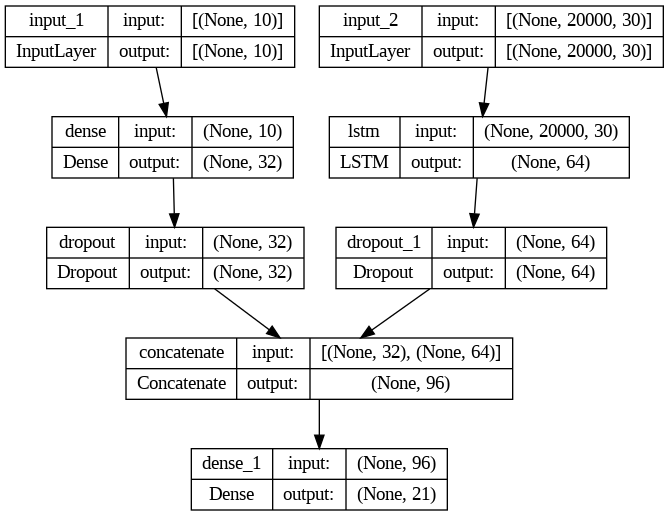

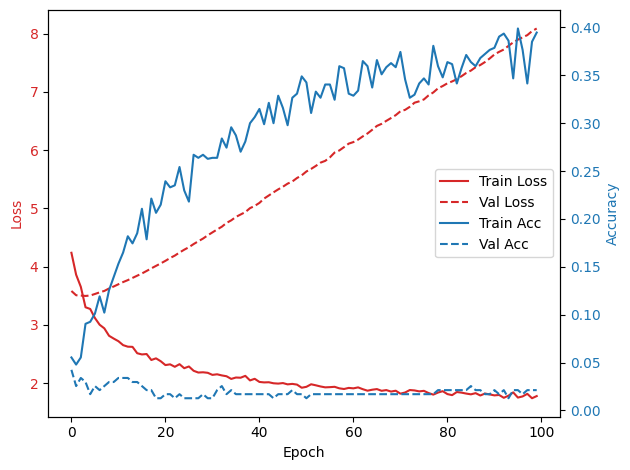

8/8 [==============================] - 2s 232ms/step


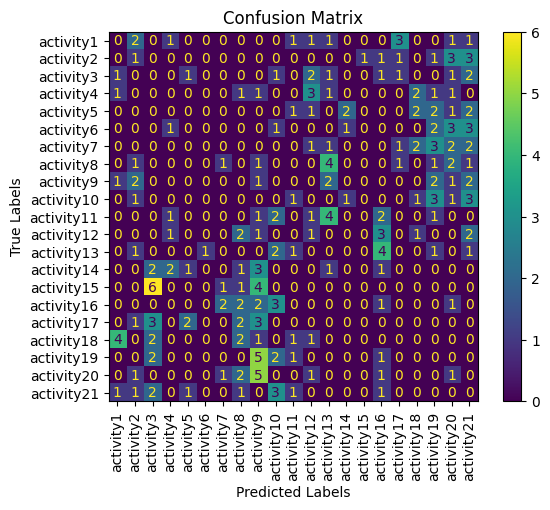

y_val (236, 21)


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model on the validation set
y_val_pred = model.predict([scalar_X_val_dr, X_sequence_val_padded_transposed])
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert probabilities to class labels

y_val_true_classes = np.argmax(y_val, axis=1)  # Convert one-hot encoded labels to class labels

# Calculate metrics
accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
precision = precision_score(y_val_true_classes, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true_classes, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


from keras.utils import plot_model
!pip install networkx
from IPython.display import Image, display

# Generate the plot
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the image in the notebook
display(Image(filename='model.png'))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
line1, = ax1.plot(history.history['loss'], color=color, label='Train Loss')
line2, = ax1.plot(history.history['val_loss'], color=color, linestyle='dashed', label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
line3, = ax2.plot(history.history['accuracy'], color=color, label='Train Acc')
line4, = ax2.plot(history.history['val_accuracy'], color=color, linestyle='dashed', label='Val Acc')
ax2.tick_params(axis='y', labelcolor=color)

# Added this line
lns = [line1, line2, line3, line4]
ax1.legend(handles=lns, loc='center right')

fig.tight_layout()
plt.show()

# Make predictions using the trained model
y_pred = model.predict([scalar_X_val_dr, X_sequence_val_padded_transposed])

# Convert the one-hot encoded predictions back to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
classes = ['activity' + str(x+1) for x in range(0, 21)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='viridis', values_format='d')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)
plt.show()

print("y_val", y_val.shape)
